# Exploratory Analysis of Loan Dataset from Prosper 

## Dataset

This is the analysis of Prosper's loan dataset, a personal loan company that provides a peer-to-peer lending marketplace.

For this analysis, I intended to better understand how Prosper's rating system works, therefore I analyzed the relationship between Prosper Rating and some selected features.

In [1]:
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
full_loans = pd.read_csv('prosperLoanData.csv')
loans = full_loans.copy()

In [3]:
# select and drop the listings that have 'ProsperRating'
# and the listings of borrowers with no prior PROSPER loans

loans['ListingCreationDate'] = pd.to_datetime(loans['ListingCreationDate'])

l1 = loans[loans['ListingCreationDate'] < '2009-07-01'].index.tolist()
l2 = loans[loans['ScorexChangeAtTimeOfListing'].notna()].index.tolist()
l3 = loans[loans['TotalProsperLoans'].notna()].index.tolist()

loans.drop(labels=l1+l2+l3, inplace=True)
loans = loans.reset_index(drop=True)

In [4]:
# create a new column 'CreditScoreRange'
loans['CreditScore'] = loans[['CreditScoreRangeLower', 'CreditScoreRangeUpper']].mean(axis=1)
# adjust by 0.5 as this doesn't really make a difference to the data since it is a range
loans['CreditScore'] += 0.5
loans['CreditScore'] = loans['CreditScore'].astype(int)

# create a new column 'ExpectedMonthlyDebt'
loans['ExpectedMonthlyDebt'] = loans['DebtToIncomeRatio'] * loans['StatedMonthlyIncome']

# select and reorder the attributes that will be analyzed
columns = ['ProsperRating (Alpha)', 'ProsperScore', 'CreditScore', 'Occupation', 'EmploymentStatus', 
           'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 
           'DebtToIncomeRatio', 'TotalInquiries', 'CurrentDelinquencies', 'BankcardUtilization', 'TradesNeverDelinquent (percentage)']

loans = loans[columns]

loans.rename(columns={'ProsperRating (Alpha)': 'ProsperRating', 'TradesNeverDelinquent (percentage)': 'TradesNeverDelinquentRatio'},
             inplace=True)

#### Change datatypes

In [5]:
categories = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
categories = pd.api.types.CategoricalDtype(categories, True)
loans.ProsperRating = loans.ProsperRating.astype(categories)

categories = ['Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']
categories = pd.api.types.CategoricalDtype(categories, ordered=True)
loans.loc[:, 'IncomeRange'] = loans.loc[:, 'IncomeRange'].astype(categories)

categories = loans.EmploymentStatus.unique()
categories = pd.api.types.CategoricalDtype(categories)
loans.loc[:, 'EmploymentStatus'] = loans.loc[:, 'EmploymentStatus'].astype(categories)

In [6]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65056 entries, 0 to 65055
Data columns (total 15 columns):
ProsperRating                 65056 non-null category
ProsperScore                  65056 non-null float64
CreditScore                   65056 non-null int64
Occupation                    63749 non-null object
EmploymentStatus              65056 non-null category
EmploymentStatusDuration      65041 non-null float64
IsBorrowerHomeowner           65056 non-null bool
IncomeRange                   65056 non-null category
IncomeVerifiable              65056 non-null bool
StatedMonthlyIncome           65056 non-null float64
DebtToIncomeRatio             59833 non-null float64
TotalInquiries                65056 non-null float64
CurrentDelinquencies          65056 non-null float64
BankcardUtilization           65056 non-null float64
TradesNeverDelinquentRatio    65056 non-null float64
dtypes: bool(2), category(3), float64(8), int64(1), object(1)
memory usage: 5.3+ MB


In [9]:
base_c1 = sb.color_palette('muted', 9)[0]
base_c2 = sb.color_palette('muted', 9)[1]

## Univariate Exploration

### Distribution of the Ratings and of the Scores
Prosper Rating and Prosper Score are fairly well distributed, slightly right-skewed.

What is interesting is how Credit Score has different distribution when compared to these two. Since Prosper Rating is built based on Prosper Score and CreditScore, I was expecting similar distributions.

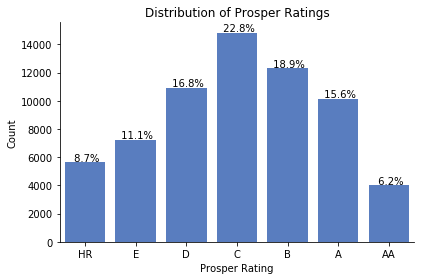

In [8]:
# check the distribution of ProsperRatings
sb.countplot(x=loans['ProsperRating'], color=base_c1)

locs, labels = plt.xticks()

counts = loans.groupby('ProsperRating').size()
total = loans.shape[0]
ticks, labels = plt.xticks()

for tick, label in zip(ticks, labels):
    count = counts.loc[label.get_text()]
    plt.text(x=tick, y=count+100, s=f'{(100*count/total): .1f}%', ha='center') 
plt.title('Distribution of Prosper Ratings')
plt.xlabel('Prosper Rating')
plt.ylabel('Count')
sb.despine(top=True)
plt.tight_layout();

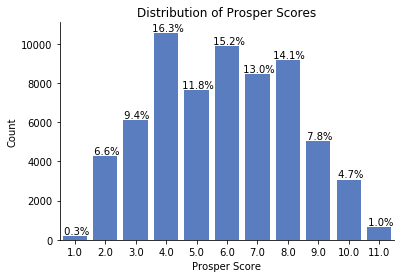

In [10]:
# check the distribution of ProsperScore

sb.countplot(x=loans['ProsperScore'], color=base_c1)

locs, labels = plt.xticks()

counts = loans.groupby('ProsperScore').size()
total = loans.shape[0]
ticks, labels = plt.xticks()

for tick, i in zip(ticks, range(1,12)):
    count = counts[i]
    plt.text(x=tick, y=count+100, s=f'{(100*count/total): .1f}%', ha='center') 

plt.title('Distribution of Prosper Scores')
plt.xlabel('Prosper Score')
plt.ylabel('Count')
sb.despine(top=True)

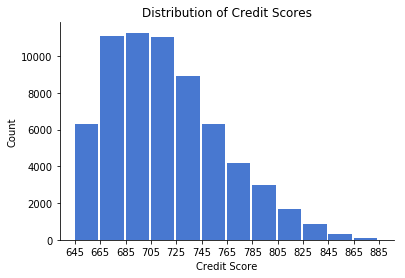

In [11]:
bins = np.arange(loans.CreditScore.min()-5, loans.CreditScore.max()+5, 20)
plt.hist(loans.CreditScore, bins=bins, width=18.5, color=base_c1)
plt.xticks(bins)
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Count')
sb.despine(top=True);

### Distribution of the Secondary Features
The data for Income and Debt are fairly bell-shaped, slightly skewed.

For the other features, however, the distribution is very uneven, with many values lying in one of the extremes, what may make the analysis difficult.

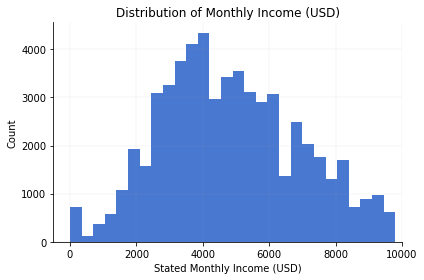

In [12]:
# ax2
bins = np.arange(0, 10000, 350)
plt.hist(loans.StatedMonthlyIncome, bins=bins, color=base_c1);
plt.xlim(-500, 10000)
plt.xlabel('StatedMonthlyIncome')
plt.ylabel('count')
plt.grid(lw=0.1)

plt.title('Distribution of Monthly Income (USD)')
plt.xlabel('Stated Monthly Income (USD)')
plt.ylabel('Count')

# axs
sb.despine(top=True)
plt.tight_layout();

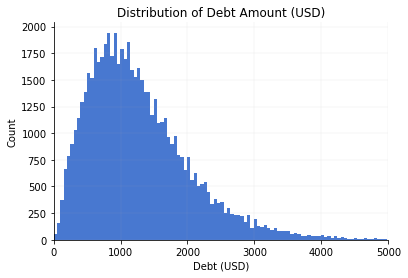

In [13]:
# remove the outliers
sl = loans[loans['ExpectedMonthlyDebt'] < 5000]
plt.hist(data=sl, x='ExpectedMonthlyDebt', bins=100, color=base_c1);
plt.xlim(0, 5000)
plt.grid(lw=0.1)

plt.title('Distribution of Debt Amount (USD)')
plt.xlabel('Debt (USD)')
plt.ylabel('Count')

sb.despine(top=True);

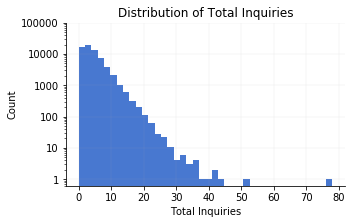

In [20]:
plt.figure(figsize=(5, 3))
plt.hist(loans['TotalInquiries'], bins=40, color=base_c1)
plt.yscale('log')
plt.grid(lw=0.1)

t = [1, 10, 100, 1000, 10000, 100000]
plt.yticks(t, t)

plt.title('Distribution of Total Inquiries')
plt.xlabel('Total Inquiries')
plt.ylabel('Count')

sb.despine(top=True);

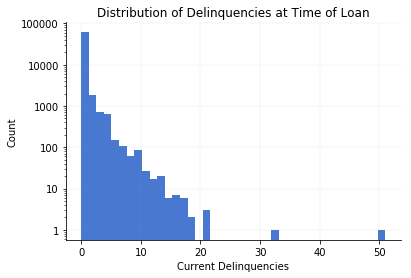

In [21]:
plt.hist(loans['CurrentDelinquencies'], bins=40, color=base_c1)
plt.yscale('log')
plt.title('Distribution of Delinquencies at Time of Loan')
plt.xlabel('Current Delinquencies')
plt.ylabel('Count')
t = [1, 10, 100, 1000, 10000, 100000]
plt.yticks(t, t)
plt.grid(lw=0.1)
sb.despine(top=True)

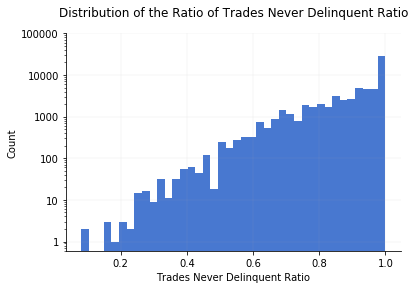

In [22]:
plt.hist(loans['TradesNeverDelinquentRatio'], bins=40, color=base_c1)
plt.yscale('log')
plt.title('Distribution of the Ratio of Trades Never Delinquent Ratio', y=1.05)
plt.xlabel('Trades Never Delinquent Ratio')
plt.ylabel('Count')
plt.grid(lw=0.1)
plt.yticks([1, 10, 100, 1000, 10000, 100000], [1, 10, 100, 1000, 10000, 100000])
sb.despine(top=True)

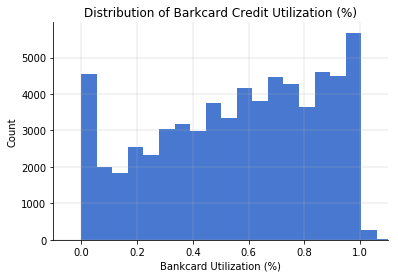

In [23]:
plt.hist(loans.BankcardUtilization, bins=40, color=base_c1)
plt.xlim(-0.1, 1.1)
plt.grid(linewidth=0.3)

plt.title('Distribution of Barkcard Credit Utilization (%)')
plt.xlabel('Bankcard Utilization (%)')
plt.ylabel('Count')
sb.despine(top=True);

## Bivariate Exploration

### Ratings and Scores
In both distributions, we can see shifting of the distribution along the x-axis as Prosper Raiting rises.

A lot of values lie on the borders of the main ratings, showing a more broad distribution than I initially expected.

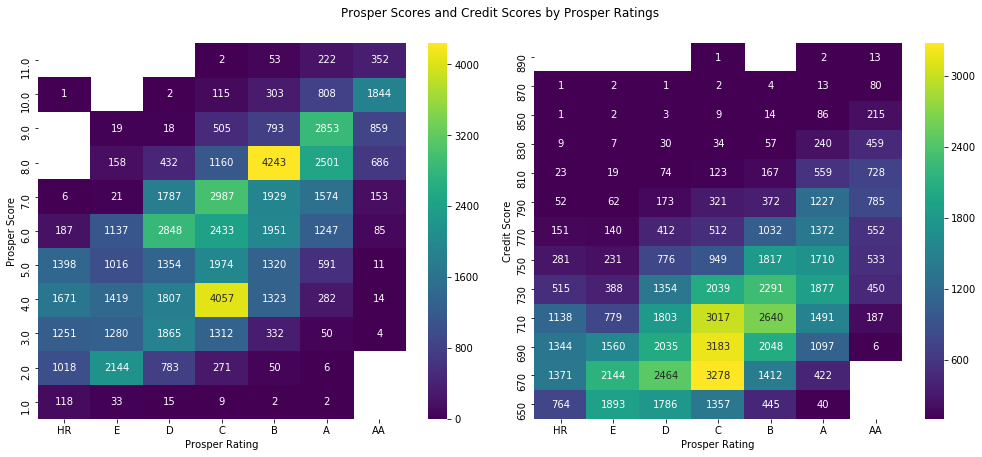

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,6))

fig.suptitle('Prosper Scores and Credit Scores by Prosper Ratings', x=0.5, y=1.05)

# ax1
counts = loans.groupby(['ProsperScore', 'ProsperRating']).size()
counts = counts.reset_index(name = 'count')
counts = counts.pivot(index = 'ProsperScore', columns = 'ProsperRating', values = 'count')

sb.heatmap(counts, annot=True, fmt='.0f', ax=ax1, cmap='viridis')
ax1.invert_yaxis()

ax1.set_xlabel('Prosper Rating')
ax1.set_ylabel('Prosper Score')

# ax2
counts = loans.groupby(['ProsperRating', 'CreditScore']).size()
counts = counts.reset_index(name = 'count')
counts = counts.pivot(index = 'CreditScore', columns = 'ProsperRating', values = 'count')

sb.heatmap(counts, annot=True, fmt='.0f', ax=ax2, cmap='viridis', vmin=100)

ax2.set_xlabel('Prosper Rating')
ax2.set_ylabel('Credit Score')

ax2.invert_yaxis()
plt.tight_layout();

## Multivariate Exploration
I could at last observe that Prosper Rating is more influenced by Prosper Score than by CreditScore, since high Prosper Ratings are more related to high Prosper Scores than to high CreditScores.

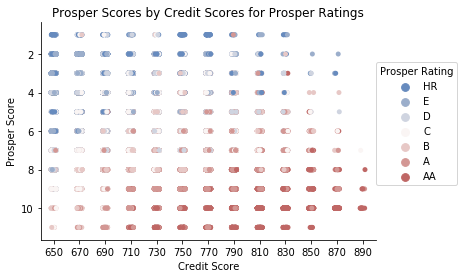

In [41]:
plt.title('Prosper Scores by Credit Scores for Prosper Ratings')

plot = sb.stripplot(y='ProsperScore', x='CreditScore', hue='ProsperRating', palette='vlag', data=loans, jitter=True)
plt.legend(title='Prosper Rating', loc=(1, 0.25))
plot.invert_yaxis()
sb.despine(top=True)
plt.ylabel('Prosper Score')
plt.xlabel('Credit Score');

For the other features, the multivariate investigation did not give very good hints of how Prosper Rating is formed, but it became more clear of how the features influence each one of the Scores.

For each one of them, it seems that that CreditScore is somehow more influenced by the features.

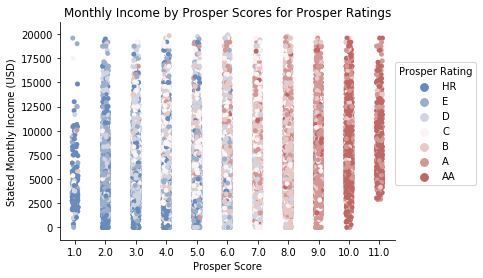

In [42]:
# remove the outliers
sl = loans[loans['StatedMonthlyIncome'] < 20000]

sb.stripplot(x='ProsperScore', y='StatedMonthlyIncome', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Monthly Income by Prosper Scores for Prosper Ratings')
plt.ylabel('Stated Monthly Income (USD)')
plt.xlabel('Prosper Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True);

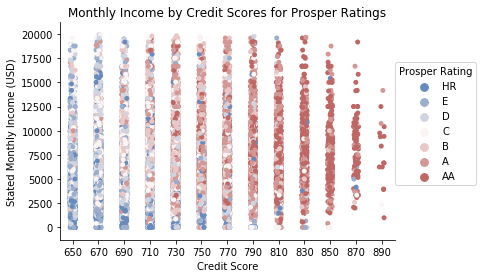

In [43]:
# remove the outliers
sl = loans[loans['StatedMonthlyIncome'] < 20000]

sb.stripplot(x='CreditScore', y='StatedMonthlyIncome', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Monthly Income by Credit Scores for Prosper Ratings')
plt.ylabel('Stated Monthly Income (USD)')
plt.xlabel('Credit Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True)

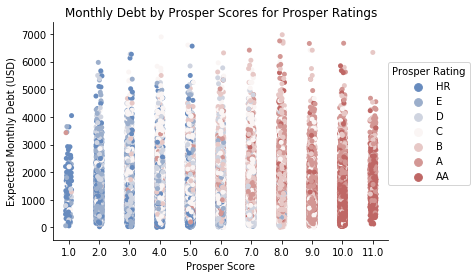

In [44]:
# remove the outliers
sl = loans[loans['ExpectedMonthlyDebt'] < 7000]
sb.stripplot(x='ProsperScore', y='ExpectedMonthlyDebt', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Monthly Debt by Prosper Scores for Prosper Ratings')
plt.ylabel('Expected Monthly Debt (USD)')
plt.xlabel('Prosper Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True);

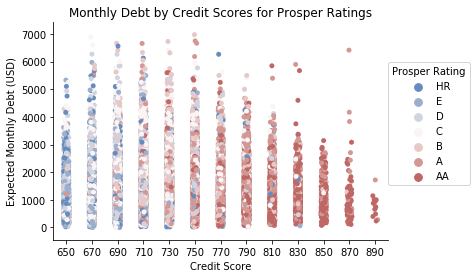

In [45]:
# remove the outliers
sl = loans[loans['ExpectedMonthlyDebt'] < 7000]
sb.stripplot(x='CreditScore', y='ExpectedMonthlyDebt', hue='ProsperRating', palette='vlag', data=sl)

plt.title('Monthly Debt by Credit Scores for Prosper Ratings')
plt.ylabel('Expected Monthly Debt (USD)')
plt.xlabel('Credit Score')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
sb.despine(top=True);

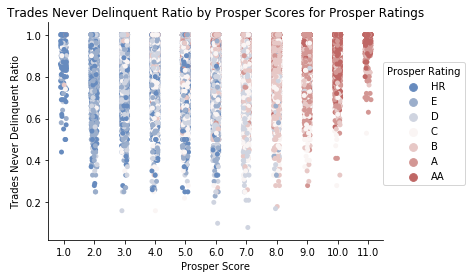

In [48]:
sb.stripplot(x='ProsperScore', y='TradesNeverDelinquentRatio', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Trades Never Delinquent Ratio by Prosper Scores for Prosper Ratings')
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Trades Never Delinquent Ratio')
plt.xlabel('Prosper Score')
sb.despine(top=True);

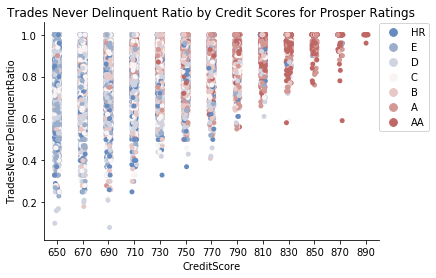

In [50]:
sb.stripplot(x='CreditScore', y='TradesNeverDelinquentRatio', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Trades Never Delinquent Ratio by Credit Scores for Prosper Ratings')
plt.legend(loc=(1, 0.5))
sb.despine(top=True);

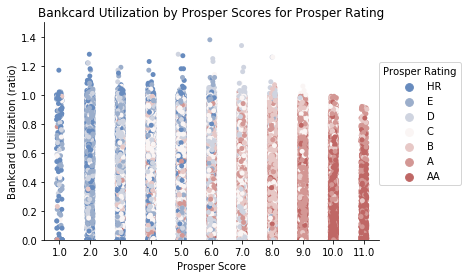

In [51]:
sb.stripplot(x='ProsperScore', y='BankcardUtilization', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Bankcard Utilization by Prosper Scores for Prosper Rating')
plt.ylim(0,1.5)
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Bankcard Utilization (ratio)')
plt.xlabel('Prosper Score')
sb.despine(top=True);

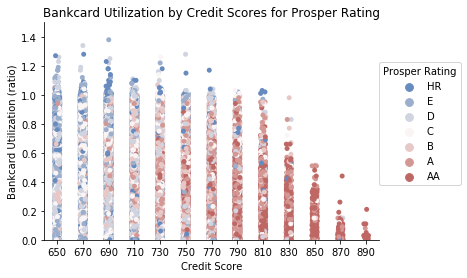

In [52]:
sb.stripplot(x='CreditScore', y='BankcardUtilization', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Bankcard Utilization by Credit Scores for Prosper Rating')
plt.ylim(0,1.5)
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Bankcard Utilization (ratio)')
plt.xlabel('Credit Score')
sb.despine(top=True);

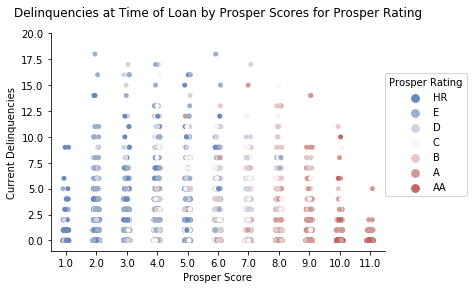

In [54]:
sb.stripplot(x='ProsperScore', y='CurrentDelinquencies', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Delinquencies at Time of Loan by Prosper Scores for Prosper Rating', y=1.05)
plt.ylim(-1,20)
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Current Delinquencies')
plt.xlabel('Prosper Score')
sb.despine(top=True);

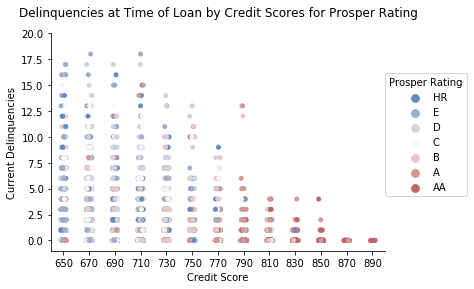

In [55]:
sb.stripplot(x='CreditScore', y='CurrentDelinquencies', hue='ProsperRating', palette='vlag', data=loans)

plt.title('Delinquencies at Time of Loan by Credit Scores for Prosper Rating', y=1.05)
plt.ylim(-1,20)
plt.legend(loc=(1, 0.25), title='Prosper Rating')
plt.ylabel('Current Delinquencies')
plt.xlabel('Credit Score')
sb.despine(top=True);